В данном ноутбуке решил попробовать уже существующую модели для решения данной задачи, и дообучить на свои данные. https://huggingface.co/Helsinki-NLP/opus-mt-ru-en?text=%D0%9C%D0%B5%D0%BD%D1%8F+%D0%B7%D0%BE%D0%B2%D1%83%D1%82+%D0%92%D0%BE%D0%BB%D1%8C%D1%84%D0%B3%D0%B0%D0%BD%D0%B3+%D0%B8+%D1%8F+%D0%B6%D0%B8%D0%B2%D1%83+%D0%B2+%D0%91%D0%B5%D1%80%D0%BB%D0%B8%D0%BD%D0%B5

Модель, которая используется описана здесь. https://arxiv.org/abs/1909.02074

In [1]:
! pip install datasets transformers[sentencepiece] sacrebleu

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [1]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:587: FutureWarning: HfApi.login: This method is deprecated in favor of `set_access_token` and will be removed in v0.8.
  FutureWarning,


In [4]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


### Prepare data

In [2]:
model_checkpoint = "Helsinki-NLP/opus-mt-ru-en"

In [3]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.7/dist-packages/transformers/models/marian/tokenization_marian.py:196: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [4]:
if "mbart" in model_checkpoint:
    tokenizer.src_lang = "ru_RU"
    tokenizer.tgt_lang = "en_XX"

In [5]:
if model_checkpoint in ["t5-small", "t5-base", "t5-larg", "t5-3b", "t5-11b"]:
    prefix = "translate English to Romanian: "
else:
    prefix = ""

In [6]:
import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
File ‘data.txt’ already there; not retrieving.



In [7]:
with open('data.txt', 'r') as f:
  lines = f.readlines()

In [8]:
from datasets import load_dataset, load_metric, DatasetDict, Dataset
metric = load_metric("sacrebleu")

In [9]:
all_dict = {name: {'Translation':[]} for name in ['train', 'validation', 'test']}
for idx, line in enumerate(lines):
  if idx<40000:
    trg, src = line.split('\t')
    all_dict['train']['Translation'].append(dict({'ru':src[:-2], 'en' : trg}))
  elif idx<45000:
    trg, src = line.split('\t')
    all_dict['validation']['Translation'].append(dict({'ru':src[:-2], 'en' : trg}))
  else:
    trg, src = line.split('\t')
    all_dict['test']['Translation'].append(dict({'ru':src[:-2], 'en' : trg}))

In [10]:
train_dataset = Dataset.from_dict(all_dict['train'])
validation_dataset = Dataset.from_dict(all_dict['validation'])
test_dataset = Dataset.from_dict(all_dict['test'])


In [11]:
raw_datasets = DatasetDict({
    'train': train_dataset,
    'test':test_dataset,
    'valid':validation_dataset})

In [12]:
max_input_length = 128
max_target_length = 128
source_lang = "ru"
target_lang = "en"

def preprocess_function(examples):
    inputs = [prefix + ex[source_lang] for ex in examples["Translation"]]
    targets = [ex[target_lang] for ex in examples["Translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [13]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [14]:
show_random_elements(raw_datasets["train"])

,Translation
0,"{'en': 'The property offers free parking.', 'ru': 'К услугам гостей бесплатная парковка'}"
1,"{'en': 'The house features a flat-screen cable TV, a DVD player, a fully equipped kitchen with microwave, a seating area and 2 bathrooms with shower and free toiletries.', 'ru': 'В распоряжении гостей телевизор с плоским экраном и кабельными каналами, DVD-плеер, полностью оборудованная кухня с микроволновой печью и гостиный уголок. В 2 ванных комнатах с душем предоставляются бесплатные туалетно-косметические принадлежности'}"
2,"{'en': 'Guests can take ferries to the Aran Islands 30 km away.', 'ru': 'Гости также могут отправиться на пароме до острова Аран, в 30 км от отеля'}"
3,"{'en': 'Guests at this hotel enjoy free Wi-Fi and an idyllic terrace directly on the River Ahr. Hotel-Restaurant Ruland is situated in Altenahr town centre, a 3-minute walk from Altenahr Train Station.', 'ru': 'Отель-ресторан Ruland с бесплатным WiFi и идиллической террасой прямо на берегу реки Ар расположен в центре города Альтенар, в 3 минутах ходьбы от железнодорожного вокзала'}"
4,"{'en': 'Guests can cook in the kitchen, equipped with fridge, stove, dishwasher, toaster, electric kettle and microwave, or eat out in the cafés and restaurants nearby.', 'ru': 'В распоряжении гостей кухня с холодильником, плитой, посудомоечной машиной, тостером, электрическим чайником и микроволновой печью, а также кафе и рестораны неподалеку'}"


In [15]:
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

  0%|          | 0/40 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

### Create model

In [16]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint).to("cuda")

In [17]:
model_checkpoint

'Helsinki-NLP/opus-mt-ru-en'

In [21]:
batch_size = 64
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-{source_lang}-to-{target_lang}",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=5,
    predict_with_generate=True)

In [22]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [23]:
import numpy as np

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

### Train model

In [24]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

We can now finetune our model by just calling the `train` method:

In [25]:
metrics = trainer.train()

The following columns in the training set don't have a corresponding argument in `MarianMTModel.forward` and have been ignored: Translation. If Translation are not expected by `MarianMTModel.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 40000
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 3125


Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,1.531800,1.175962,35.335700,20.786400
2,1.223100,1.093607,36.856200,20.756600
3,1.123000,1.059592,37.644200,20.648800
4,1.027600,1.040842,37.986600,20.810600
5,0.997200,1.036091,38.202200,20.787600


Saving model checkpoint to opus-mt-ru-en-finetuned-ru-to-en/checkpoint-500
Configuration saved in opus-mt-ru-en-finetuned-ru-to-en/checkpoint-500/config.json
Model weights saved in opus-mt-ru-en-finetuned-ru-to-en/checkpoint-500/pytorch_model.bin
tokenizer config file saved in opus-mt-ru-en-finetuned-ru-to-en/checkpoint-500/tokenizer_config.json
Special tokens file saved in opus-mt-ru-en-finetuned-ru-to-en/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `MarianMTModel.forward` and have been ignored: Translation. If Translation are not expected by `MarianMTModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 64
Saving model checkpoint to opus-mt-ru-en-finetuned-ru-to-en/checkpoint-1000
Configuration saved in opus-mt-ru-en-finetuned-ru-to-en/checkpoint-1000/config.json
Model weights saved in opus-mt-ru-en-finetuned-ru-to-en/checkpoint-1000/pytorch_

## Check quality of network

In [26]:
test_metrics = trainer.evaluate(tokenized_datasets["test"])

The following columns in the evaluation set don't have a corresponding argument in `MarianMTModel.forward` and have been ignored: Translation. If Translation are not expected by `MarianMTModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 64


In [69]:
test_metrics

{'epoch': 5.0,
 'eval_bleu': 37.9501,
 'eval_gen_len': 20.7894,
 'eval_loss': 1.037621259689331,
 'eval_runtime': 262.8196,
 'eval_samples_per_second': 19.024,
 'eval_steps_per_second': 0.301}

In [28]:
import torch

In [66]:
model1 = model.to(torch.device('cuda'))

In [61]:
translator = pipeline("translation", tokenizer = tokenizer, model=model1)

In [64]:
translator("И английский учить не надо")

[{'translation_text': 'There is no need for English lessons.'}]

In [73]:
bleu = [35.335700, 36.856200, 37.644200, 37.986600, 38.202200]
train_losses = [1.531800, 1.223100, 1.123000, 1.027600, 0.997200]
valid_losses = [1.175962, 1.093607, 1.059592, 1.040842, 1.036091]

In [76]:
import matplotlib.pyplot as plt

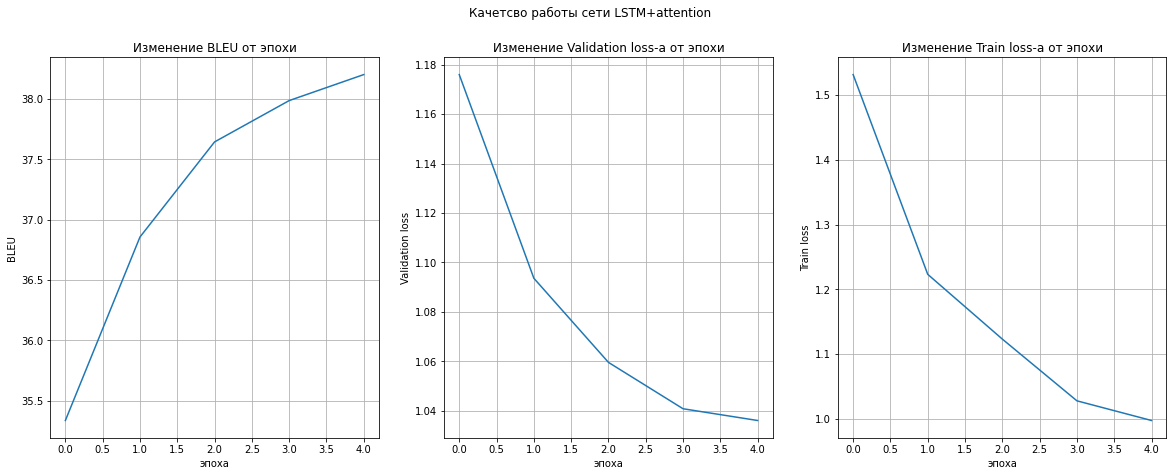

In [77]:
fig, axs = plt.subplots(1,3, figsize = (20,7))
fig.suptitle('Качетсво работы сети LSTM+attention')
axs[0].set_title('Изменение BLEU от эпохи')
axs[0].set_xlabel('эпоха')
axs[0].set_ylabel('BLEU')
axs[0].grid()
axs[0].plot(range(len(bleu)), bleu)

axs[1].set_title('Изменение Validation loss-a от эпохи')
axs[1].set_xlabel('эпоха')
axs[1].set_ylabel('Validation loss')
axs[1].grid()
axs[1].plot(range(len(valid_losses)), valid_losses)

axs[2].set_title('Изменение Train loss-a от эпохи')
axs[2].set_xlabel('эпоха')
axs[2].set_ylabel('Train loss')
axs[2].grid()
axs[2].plot(range(len(train_losses)), train_losses)
plt.show();

# Краткий обзор

В этой игре хотелось посмотреть качество работы уже существующих сетей. Качетсво получилось хорошим. Использовать huggingface.co для дообучения под свои задачи оказалось просто, я доволен)

bleu получился меньше, чем у сверточной сети, но переводы как по мне лучше
### Метрики: 
train. Loss: 0.997200 |  train. PPL:   2.71068 | 	

test. Loss: 1.0376  |  test. PPL:   2.82243  | test. bleu: 37.9501

Val. Loss: 1.036091   |  Val. PPL:   2.818   | val. bleu: 38.202200	

### Хорошие и плохие переводы:
Good

1.

predicted: Activities in the surrounding area include hiking, cycling and skiing.   

Original: Activities in the area include hiking, cycling, and skiing.

2.

Predicted: Local restaurants are 4 km away. 

Original: Local restaurants are available within a 4 km radius.

Bad

1.

Predicted:	This homelyly, historic suite hotel is located in the centre of city activity, just steps from the most popular attractions of Nashville, and offers fully equipped kitchens.

Original:  Only steps from Nashville's most popular attractions, this all-suite historic hotel offers all the comforts of home, including full kitchens, and is ideally placed in the center of all the action.

Другие плохие переводы найти было сложно

### Графики обучения также предствалены выше.

### Скорость обучения:
9 минут на эпоху, где батч = 64, 
### Cкорость инференса:

10 секунд. Но мне кажется я неправильно вызывал.
На батч из 32